In [75]:
# 初始環境設定
import os
from pathlib import Path
HOME = str(Path.home())
Add_Binarry_Path=HOME+'/.local/bin'
os.environ['PATH']=os.environ['PATH']+':'+Add_Binarry_Path

In [ ]:
## QA normal 1

## OPENAI KEY
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = "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"
)

response = client.chat.completions.create(
  #model="nvidia/nemotron-4-340b-instruct",
  model="microsoft/phi-3-medium-4k-instruct",    
  messages=[{"role":"user","content":"請介紹五樣台灣小吃"}],
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
)
print(response.choices[0].message.content)

## Data Input

In [78]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('mimic_sleep.csv')
print(df.head())

In [ ]:
df.info
df.describe()
print(list(df.columns))

In [5]:
df = df.drop('blood_pressure', axis=1)

In [6]:
df.shape

(6214, 155)

In [ ]:
df.columns

### From SQL

In [ ]:
import psycopg2

# Define connection parameters
connection_params = {
    "host": "host.docker.internal",  # Replace with your host
    "dbname": "mimiciv30",  # Replace with your database name
    "user": "datathon001",  # Replace with your username
    "password": "datathon001@1234QWER",  # Replace with your password
    "port": "5432"  # Default PostgreSQL port is 5432
}

# Establish the connection
try:
    conn = psycopg2.connect(**connection_params)
    print("Connection established")
except Exception as e:
    print(f"Error connecting to the database: {e}")
    exit()

# Create a cursor object
cur = conn.cursor()

# Close the cursor and connection
#cur.close()
#conn.close()

In [ ]:
import pandas as pd
import psycopg2

# Define SQL query
query = """
    SELECT * 
    FROM test3 
"""

# Execute the query
try:
    cur.execute(query)
    # Fetch all the results
    rows = cur.fetchall()

    # Optional: Convert to a pandas DataFrame for easier handling and display
    columns = [desc[0] for desc in cur.description]
    df = pd.DataFrame(rows, columns=columns)

    #print(df.head())  # Display first few rows of the result
    print(df.head(100))  # Display first few rows of the result

except Exception as e:
    print(f"Error executing the query: {e}")

In [ ]:
len(df)
type(df)
os.getcwd()
df.to_csv('/home/jovyan/work/test3.csv',index=False)

### 分icu:1、nicu:0 (Outcome)
有沒有進ICU

In [7]:
df['icu_coding'] = df['icu_intime'].apply(lambda x: 1 if pd.notna(x) else 0)

# 將資料分成兩個群
# groups = df.groupby(df.icu_intime_flag)
# df_nicu = groups.get_group(0)
# df_icu = groups.get_group(1)

## Data preprocssing

- **Data imputation**
  - Continuous Variable
     + mean(group-wise)
  - Categorical Variable
     + set "UNKNOWN"
- **Data transformation**
  - onehot
  - minmax
  - binary當作一項 #

### Data Imputation

In [ ]:
def calculate_mean_and_fill_na(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            mean_val = df[col].dropna().mean()
            df.loc[:, col] = df[col].fillna(mean_val)
    return df
df = calculate_mean_and_fill_na(df)
df.head()

In [172]:
df = df.fillna('UNKNOWN')
df.columns[df.isna().any()]
df.isna().sum()

Index([], dtype='object')

In [173]:
# df_final = pd.concat([df_icu, df_nicu])

df_final.to_csv('/home/jovyan/work/combined_sinyu.csv',index=False)

#### Checking

補法：
  - 刪除 blood_pressure 欄位
  - 新增icu編碼欄位 icu_coding（有進icu=1）（在最後的column）
  - 最後兩row分別是原始數據的missing ratio跟unknown ratio
  - 扣除到'hours_to_icu', 'edregtime', 'icu_intime'這三個欄位的數值，其餘數值型變數都補全部人的平均，類別型變數補UNKNOWN自己當作一項

In [8]:
# preprocessed data
df_final = pd.read_csv('mimic_preprocessed.csv')

In [9]:
df = df_final
# 若有任何元素為True則回傳True，可檢查是否有遺失值
df.isnull().values.any() 

na_cols = []
for col in df.columns:
    if df[col].isna().sum()!=0:
        na_cols.append(col)
print(na_cols)

['edregtime', 'icu_intime', 'hours_to_icu']


### Data transformation

In [10]:
print(list(df.columns))

['subject_id', 'hadm_id', 'admittime', 'edregtime', 'icu_intime', 'hours_to_icu', 'within_48_hours', 'gender', 'age', 'race', 'language', 'marital_status', 'insurance', 'height_cm', 'weight_kg', 'bmi', 'systolic_bp', 'diastolic_bp', 'charlson_comorbidity_score', 'wbc_min', 'wbc_mean', 'wbc_median', 'wbc_max', 'hematocrit_min', 'hematocrit_mean', 'hematocrit_median', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_mean', 'hemoglobin_median', 'hemoglobin_max', 'platelet_min', 'platelet_mean', 'platelet_median', 'platelet_max', 'bun_min', 'bun_mean', 'bun_median', 'bun_max', 'creatinine_min', 'creatinine_mean', 'creatinine_median', 'creatinine_max', 'glucose_min', 'glucose_mean', 'glucose_median', 'glucose_max', 'calcium_min', 'calcium_mean', 'calcium_median', 'calcium_max', 'sodium_min', 'sodium_mean', 'sodium_median', 'sodium_max', 'potassium_min', 'potassium_mean', 'potassium_median', 'potassium_max', 'chloride_min', 'chloride_mean', 'chloride_median', 'chloride_max', 'bicarbonate_min'

In [13]:
df.tail(2)

,subject_id,hadm_id,admittime,edregtime,icu_intime,hours_to_icu,within_48_hours,gender,age,race,...,resp_rate_max,temp_min,temp_mean,temp_median,temp_max,spo2_min,spo2_mean,spo2_median,spo2_max,icu_coding
6214,missing_ratio,0,0,16.75249437,97.8918571,97.891857,0,0,0,0,...,100,100,100,100,100,100,100,100,100,0
6215,unknown_ratio,0,0,0,0,0.000000,0,0,0,0.852912778,...,0,0,0,0,0,0,0,0,0,0


- columns not used : 'subject_id', 'hadm_id', 'admittime', 'edregtime', 'icu_intime', 'hours_to_icu', 'within_48_hours'
- Xs : 'gender', 'age', 'race', 'language', 'marital_status', 'insurance', 'height_cm', 'weight_kg', 'bmi', 'systolic_bp', 'diastolic_bp', 'charlson_comorbidity_score', 'wbc_min', 'wbc_mean', 'wbc_median', 'wbc_max', 'hematocrit_min', 'hematocrit_mean', 'hematocrit_median', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_mean', 'hemoglobin_median', 'hemoglobin_max', 'platelet_min', 'platelet_mean', 'platelet_median', 'platelet_max', 'bun_min', 'bun_mean', 'bun_median', 'bun_max', 'creatinine_min', 'creatinine_mean', 'creatinine_median', 'creatinine_max', 'glucose_min', 'glucose_mean', 'glucose_median', 'glucose_max', 'calcium_min', 'calcium_mean', 'calcium_median', 'calcium_max', 'sodium_min', 'sodium_mean', 'sodium_median', 'sodium_max', 'potassium_min', 'potassium_mean', 'potassium_median', 'potassium_max', 'chloride_min', 'chloride_mean', 'chloride_median', 'chloride_max', 'bicarbonate_min', 'bicarbonate_mean', 'bicarbonate_median', 'bicarbonate_max', 'lactate_min', 'lactate_mean', 'lactate_median', 'lactate_max', 'ast_min', 'ast_mean', 'ast_median', 'ast_max', 'alt_min', 'alt_mean', 'alt_median', 'alt_max', 'alp_min', 'alp_mean', 'alp_median', 'alp_max', 'bilirubin_total_min', 'bilirubin_total_mean', 'bilirubin_total_median', 'bilirubin_total_max', 'amylase_min', 'amylase_mean', 'amylase_median', 'amylase_max', 'lipase_min', 'lipase_mean', 'lipase_median', 'lipase_max', 'crp_min', 'crp_mean', 'crp_median', 'crp_max', 'pt_min', 'pt_mean', 'pt_median', 'pt_max', 'inr_min', 'inr_mean', 'inr_median', 'inr_max', 'ldh_min', 'ldh_mean', 'ldh_median', 'ldh_max', 'albumin_min', 'albumin_mean', 'albumin_median', 'albumin_max', 'pao2_min', 'pao2_mean', 'pao2_median', 'pao2_max', 'base_excess_min', 'base_excess_mean', 'base_excess_median', 'base_excess_max', 'magnesium_min', 'magnesium_mean', 'magnesium_median', 'magnesium_max', 'phosphate_min', 'phosphate_mean', 'phosphate_median', 'phosphate_max', 'heart_rate_min', 'heart_rate_mean', 'heart_rate_median', 'heart_rate_max', 'sbp_min', 'sbp_mean', 'sbp_median', 'sbp_max', 'dbp_min', 'dbp_mean', 'dbp_median', 'dbp_max', 'resp_rate_min', 'resp_rate_mean', 'resp_rate_median', 'resp_rate_max', 'temp_min', 'temp_mean', 'temp_median', 'temp_max', 'spo2_min', 'spo2_mean', 'spo2_median', 'spo2_max'
- Y : 'icu_coding'ime_flag' (icu=1, nicu=0)

within_48_hours : 已知胰臟炎，48小時內，有沒有進icu  
what we want : 已知胰臟炎，48小時後，有沒有進icu  
'hours_to_icu' : 缺失值代表沒進icu

In [ ]:
df = df.drop(df.tail(2).index)  # drop last 2 rows
print(df)

In [15]:
df['hours_to_icu'][df['hours_to_icu'].isna()] = 999   # 沒進icu過的:999
df['hours_to_icu'].isna().sum()
# df = df.drop(columns=['miss3'])

0

In [16]:
# within_48_hours : 已知胰臟炎，48小時後，有沒有進icu
# df_48 = df[~((df['icu_coding']==1) & (df['within_48_hours']==1))]
# df_48 = df[~(df['within_48_hours']==1)]
df_48 = df[~(df['hours_to_icu']<=48)]
df_48

,subject_id,hadm_id,admittime,edregtime,icu_intime,hours_to_icu,within_48_hours,gender,age,race,...,resp_rate_max,temp_min,temp_mean,temp_median,temp_max,spo2_min,spo2_mean,spo2_median,spo2_max,icu_coding
0,10002807,28464737,2152/3/30 16:09,2152/3/30 10:00,NaN,999.000000,0,M,66,BLACK/AFRICAN AMERICAN,...,50,50,50,50,50,50,50,50,50,0
1,10006431,24638489,2129/1/24 1:08,2129/1/23 21:18,NaN,999.000000,0,F,67,WHITE,...,50,50,50,50,50,50,50,50,50,0
2,10006441,21171491,2175/11/6 19:02,2175/11/6 14:16,NaN,999.000000,0,M,52,WHITE,...,50,50,50,50,50,50,50,50,50,0
3,10006441,24120560,2174/9/10 15:43,2174/9/9 16:51,2174/9/12 16:57,72.101111,1,M,51,WHITE,...,50,50,50,50,50,50,50,50,50,1
4,10006441,24710444,2175/10/22 13:53,2175/10/22 9:56,NaN,999.000000,0,M,52,WHITE,...,50,50,50,50,50,50,50,50,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,19993764,23707485,2167/8/27 23:09,2167/8/27 21:20,NaN,999.000000,0,M,76,WHITE,...,50,50,50,50,50,50,50,50,50,0
6210,19996651,21553408,2179/12/28 23:09,2179/12/28 17:16,NaN,999.000000,0,F,58,ASIAN,...,50,50,50,50,50,50,50,50,50,0
6211,19996968,28227793,2125/2/18 16:48,2125/2/18 15:52,NaN,999.000000,0,M,32,BLACK/AFRICAN AMERICAN,...,50,50,50,50,50,50,50,50,50,0
6212,19996968,29843339,2125/1/20 21:17,NaN,NaN,999.000000,0,M,32,BLACK/AFRICAN AMERICAN,...,50,50,50,50,50,50,50,50,50,0


In [17]:
df_48['icu_coding'].value_counts()

icu_coding
0    6083
1     131
Name: count, dtype: int64

In [18]:
df_48.dtypes[df_48.dtypes=='object'].index

Index(['subject_id', 'admittime', 'edregtime', 'icu_intime', 'gender', 'race',
       'language', 'marital_status', 'insurance'],
      dtype='object')

In [19]:
df_48 = df_48.drop(columns=['subject_id', 'hadm_id', 'admittime', 'edregtime', 'icu_intime', 'hours_to_icu', 'within_48_hours'])

In [20]:
print(list(df_48.columns))

['gender', 'age', 'race', 'language', 'marital_status', 'insurance', 'height_cm', 'weight_kg', 'bmi', 'systolic_bp', 'diastolic_bp', 'charlson_comorbidity_score', 'wbc_min', 'wbc_mean', 'wbc_median', 'wbc_max', 'hematocrit_min', 'hematocrit_mean', 'hematocrit_median', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_mean', 'hemoglobin_median', 'hemoglobin_max', 'platelet_min', 'platelet_mean', 'platelet_median', 'platelet_max', 'bun_min', 'bun_mean', 'bun_median', 'bun_max', 'creatinine_min', 'creatinine_mean', 'creatinine_median', 'creatinine_max', 'glucose_min', 'glucose_mean', 'glucose_median', 'glucose_max', 'calcium_min', 'calcium_mean', 'calcium_median', 'calcium_max', 'sodium_min', 'sodium_mean', 'sodium_median', 'sodium_max', 'potassium_min', 'potassium_mean', 'potassium_median', 'potassium_max', 'chloride_min', 'chloride_mean', 'chloride_median', 'chloride_max', 'bicarbonate_min', 'bicarbonate_mean', 'bicarbonate_median', 'bicarbonate_max', 'lactate_min', 'lactate_mean', 'lacta

In [21]:
# Data transformation
# minmax (歸一化)
# scaler = MinMaxScaler()
# df[['']] = scaler.fit_transform(df[['']])

# onehot
# 對df進行One-Hot編碼
# 'gender', 'race', 'language', 'marital_status', 'insurance'
df_48 = pd.get_dummies(df_48, columns=['gender', 'race', 'language', 'marital_status', 'insurance'])

# binary
# df[''] = df[''].replace('', 0)
# df[''] = df[''].replace('', 1)
df_48['icu_coding'].dtype

dtype('int64')

In [22]:
df_48.shape

(6214, 212)

In [23]:
df_48.tail()

,age,height_cm,weight_kg,bmi,systolic_bp,diastolic_bp,charlson_comorbidity_score,wbc_min,wbc_mean,wbc_median,...,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_UNKNOWN,marital_status_WIDOWED,insurance_Medicaid,insurance_Medicare,insurance_Other,insurance_Private,insurance_UNKNOWN
6209,76,172.720000,81.646560,27.400000,149.259517,90.08168,2,7.100000,7.100000,7.100000,...,False,True,False,False,False,False,True,False,False,False
6210,58,170.093486,180.870702,34.539232,131.000000,86.00000,2,7.692158,8.503568,8.484577,...,False,True,False,False,False,False,False,True,False,False
6211,32,175.260000,77.564232,25.200000,149.259517,90.08168,0,3.900000,4.150000,4.150000,...,False,True,False,False,False,True,False,False,False,False
6212,32,175.260000,77.564232,25.200000,149.259517,90.08168,0,7.692158,8.503568,8.484577,...,False,True,False,False,False,True,False,False,False,False
6213,39,170.093486,180.870702,34.539232,149.259517,90.08168,0,6.700000,6.700000,6.700000,...,True,False,False,False,False,True,False,False,False,False


## Model training & testing

### Data splitting
- Training : 80% (4972)
- Testing : 20% (1243)

In [27]:
print(round(df_48.shape[0]*0.8))
print(round(df_48.shape[0]-df_48.shape[0]*0.8))

4971
1243


In [28]:
x = df_48.iloc[:,:-1]
y = df_48['icu_coding']

In [ ]:
list(x.columns)

In [29]:
# Split X, Y & train, test
X_train, X_test, y_train, y_test = train_test_split(df_48, y, test_size=0.2, random_state=42)

# 定義 KFold 並設置隨機種子
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [30]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4971, 212) (1243, 212) (4971,) (1243,)


In [79]:
print(y_train.value_counts())

icu_coding
0    4864
1     107
Name: count, dtype: int64


- XGBoost

In [31]:
# XGBoost
# 建立xgboost模型
from xgboost import XGBClassifier
XGB = XGBClassifier()

# 定義超參數範圍
param_grid = {
    'max_depth': [3, 4],
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'lambda': [1, 2],  # reg_lambda
    'alpha': [0, 0.1]  # reg_alpha
}

# param_grid = {
#     'max_depth': [3, 4, 5, 6],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0.5, 1, 1.5, 2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'lambda': [1, 2, 3],  # reg_lambda
#     'alpha': [0, 0.1, 0.5]  # reg_alpha
# }

# 使用 RandomizedSearchCV 進行超參數調整和10倍交叉驗證
random_search = RandomizedSearchCV(XGB, param_grid, n_iter=100, cv=cv, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)


print('------------------------------ XGBoost ------------------------------')

# 最佳參數
print("Best parameters found: ", random_search.best_params_)

# 使用最佳參數訓練最終模型
best_XGB = random_search.best_estimator_
best_XGB.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = best_XGB.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# 計算特異性 (Specificity)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# 評估指標
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"MCC: {mcc:.4f}")

# 詳細分類報告
print(classification_report(y_test, y_pred))


------------------------------ XGBoost ------------------------------
Best parameters found:  {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 4, 'lambda': 1, 'gamma': 1, 'colsample_bytree': 0.8, 'alpha': 0}
[[1219    0]
 [   0   24]]
Accuracy: 1.0000
F1 Score: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
MCC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1219
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1243
   macro avg       1.00      1.00      1.00      1243
weighted avg       1.00      1.00      1.00      1243



In [81]:
scores = cross_val_score(best_XGB, x, y, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [1. 1. 1. 1. 1.]


In [91]:
# Random Forest
# 建立 Random Forest 模型
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=(42))

# 定義超參數範圍
param_grid = {
    'n_estimators': [200, 300],  # 樹的數量
    'max_depth': [10, 20],  # 樹的最大深度
    'min_samples_split': [5, 10],  # 分割一個節點所需的最小樣本數
    'min_samples_leaf': [2, 4],  # 一個葉節點所需的最小樣本數
    'max_features': ['auto', 'sqrt']  # 選擇特徵的方式
}

# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],  # 樹的數量
#     'max_depth': [None, 10, 20, 30, 40, 50],  # 樹的最大深度
#     'min_samples_split': [2, 5, 10],  # 分割一個節點所需的最小樣本數
#     'min_samples_leaf': [1, 2, 4],  # 一個葉節點所需的最小樣本數
#     'max_features': ['auto', 'sqrt', 'log2']  # 選擇特徵的方式
# }

# 使用 RandomizedSearchCV 進行超參數調整和10倍交叉驗證
random_search = RandomizedSearchCV(RF, param_grid, n_iter=100, cv=cv, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)


print('------------------------------ Random Forest ------------------------------')

# 最佳參數
print("Best parameters found: ", random_search.best_params_)

# 使用最佳參數訓練最終模型
best_RF = random_search.best_estimator_
best_RF.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = best_RF.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# 計算特異性 (Specificity)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# 評估指標
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"MCC: {mcc:.4f}")

# 詳細分類報告
print(classification_report(y_test, y_pred))


------------------------------ Random Forest ------------------------------
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
[[1219    0]
 [   0   24]]
Accuracy: 1.0000
F1 Score: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
MCC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1219
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1243
   macro avg       1.00      1.00      1.00      1243
weighted avg       1.00      1.00      1.00      1243



In [ ]:
# shap_values[1] 用來解釋正類的 SHAP 值
# 創建 SHAP 解釋器
explainer = shap.TreeExplainer(best_RF)

# 計算 SHAP 值
shap_values = explainer.shap_values(X_test)

# 繪製 SHAP 值的總體解釋圖（summary plot）
# 顯示每個特徵對於預測結果的貢獻
shap.summary_plot(shap_values[1], X_test)  # 如果是二元分類，使用 shap_values[1]；否則使用 shap_values

In [93]:
# 檢查 SHAP 值的形狀
print(f"X_test shape: {X_test.shape}")
print(f"shap_values[0] shape: {shap_values[0].shape}")
print(f"shap_values[1] shape: {shap_values[1].shape}")

X_test shape: (1243, 212)
shap_values[0] shape: (212, 2)
shap_values[1] shape: (212, 2)


In [95]:
# # Random Forest with SHAP Analysis
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef, confusion_matrix, classification_report
# import shap
# import matplotlib.pyplot as plt

# # 建立 Random Forest 模型
# RF = RandomForestClassifier(random_state=42)

# # 定義超參數範圍
# param_grid = {
#     'n_estimators': [200, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # 使用 RandomizedSearchCV 進行超參數調整和10倍交叉驗證
# random_search = RandomizedSearchCV(RF, param_grid, n_iter=100, cv=cv, scoring='accuracy', random_state=42)
# random_search.fit(X_train, y_train)

# print('------------------------------ Random Forest ------------------------------')
# print("Best parameters found: ", random_search.best_params_)

# # 使用最佳參數訓練最終模型
# best_RF = random_search.best_estimator_
# best_RF.fit(X_train, y_train)

# # 在測試集上進行預測
# y_pred = best_RF.predict(X_test)

# # 計算評估指標
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# sensitivity = recall_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# mcc = matthews_corrcoef(y_test, y_pred)

# # 計算特異性 (Specificity)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# specificity = tn / (tn + fp)

# # 輸出結果
# print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"Sensitivity (Recall): {sensitivity:.4f}")
# print(f"Specificity: {specificity:.4f}")
# print(f"MCC: {mcc:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # SHAP值計算和可視化
# explainer = shap.TreeExplainer(best_RF)
# shap_values = explainer.shap_values(X_test)

# # 對於二元分類問題，我們通常只關注正類的SHAP值
# shap_values = shap_values[1]  # 假設正類的索引為1

# # 繪製摘要圖
# plt.figure(figsize=(10, 8))
# shap.summary_plot(shap_values, X_test, plot_type="bar")
# plt.title("SHAP Feature Importance")
# plt.tight_layout()
# plt.show()

# # 繪製詳細的SHAP值分布圖
# plt.figure(figsize=(12, 8))
# shap.summary_plot(shap_values, X_test)
# plt.title("SHAP Values Distribution")
# plt.tight_layout()
# plt.show()

In [96]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# 建立 Logistic Regression 模型
log_reg = LogisticRegression(solver='liblinear')

# 定義超參數範圍
param_grid = {
    'C': np.logspace(-4, 4, 20),  # 正則化強度的倒數，實現更多的正則化選項
    'penalty': ['l1', 'l2'] ,     # L1 和 L2 正則化
}

# 進行10倍交叉驗證和超參數調整
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 最佳參數
print("Best parameters found: ", grid_search.best_params_)

# 使用最佳參數訓練最終模型
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train, y_train)

# 在測試集上進行預測
y_pred = best_log_reg.predict(X_test)

# 計算評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# 計算特異性 (Specificity)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# 評估指標
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"MCC: {mcc:.4f}")

# 詳細分類報告
print(classification_report(y_test, y_pred))

Best parameters found:  {'C': 545.5594781168514, 'penalty': 'l1'}
Accuracy: 1.0000
F1 Score: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
MCC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1219
           1       1.00      1.00      1.00        24

    accuracy                           1.00      1243
   macro avg       1.00      1.00      1.00      1243
weighted avg       1.00      1.00      1.00      1243



In [100]:
# logistic regression 一個一個特徵加進去跑，看哪個X的特徵和Y有高度相關，造成過度擬合的問題
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# 初始化一個邏輯回歸模型
model = LogisticRegression(solver='liblinear')

# 初始化空列表來存儲結果
results = []

# 逐步將每個特徵加入到模型中進行訓練和測試
for i in range(X_train.shape[1]):
    feature_set = X_train.iloc[:, :i+1]  # 從第 0 列到當前列的所有特徵
    feature_set_test = X_test.iloc[:, :i+1]

    # 訓練模型
    model.fit(feature_set, y_train)

    # 預測訓練集和測試集
    y_train_pred = model.predict(feature_set)
    y_test_pred = model.predict(feature_set_test)

    # 計算訓練集和測試集的準確率和 AUC 分數
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # 存儲結果：包括特徵數量、訓練集準確率、測試集準確率、AUC 分數
    results.append({
        'num_features': i+1,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'f1_score': f1
    })

# 將結果轉換為 DataFrame 以便查看
results_df = pd.DataFrame(results)

# 打印結果，找出有過度擬合問題的特徵組合
print(results_df)

     num_features  train_accuracy  test_accuracy  train_auc  test_auc  \
0               1        0.978475       0.980692   0.500000  0.500000   
1               2        0.978475       0.980692   0.500000  0.500000   
2               3        0.978475       0.980692   0.500000  0.500000   
3               4        0.978475       0.980692   0.500000  0.500000   
4               5        0.978475       0.980692   0.500000  0.500000   
..            ...             ...            ...        ...       ...   
207           208        0.979682       0.977474   0.564598  0.518782   
208           209        0.981090       0.979887   0.597308  0.560859   
209           210        0.979280       0.977474   0.564393  0.518782   
210           211        0.979280       0.977474   0.564393  0.518782   
211           212        0.979682       0.977474   0.555458  0.518782   

     f1_score  
0    0.000000  
1    0.000000  
2    0.000000  
3    0.000000  
4    0.000000  
..        ...  
207  0.0666

## Correlation Checking

In [32]:
# 檢查所有變項和y的相關性
corr = df_48.corr()['icu_coding'].dropna()

# 列印相關性結果
print(corr[corr>0.5])

icu_coding    1.0
Name: icu_coding, dtype: float64


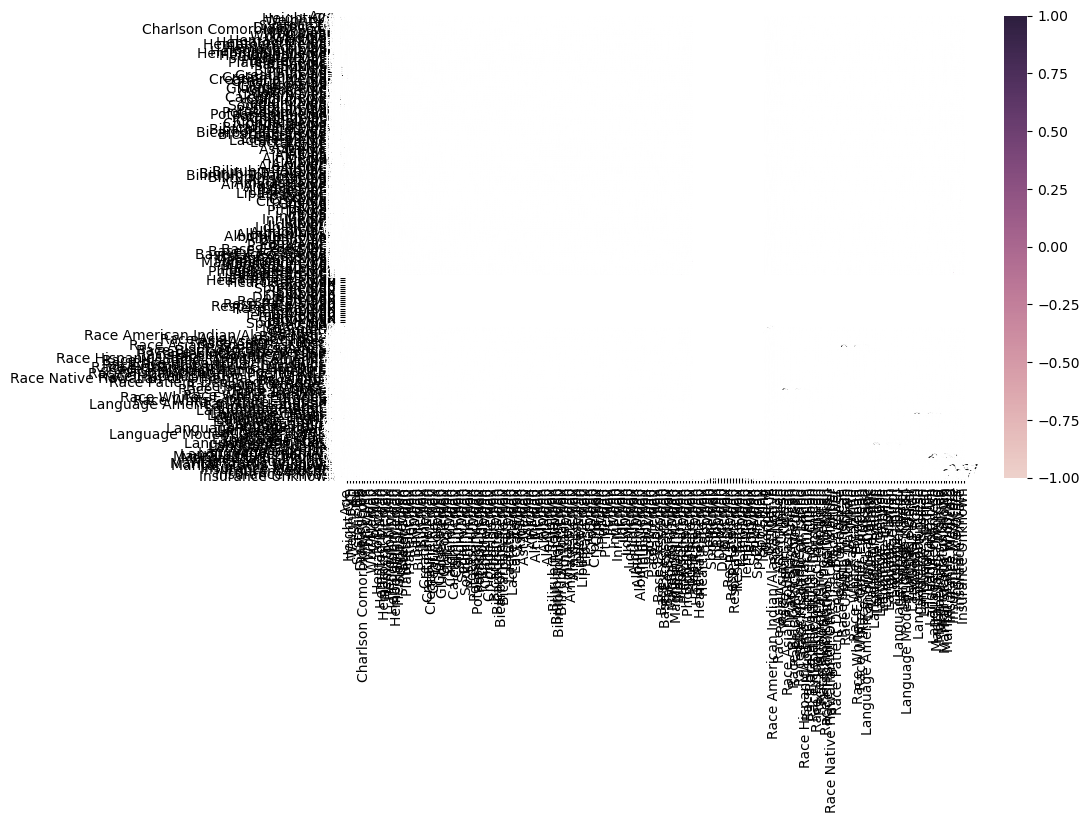

In [39]:
h_labels = [x.replace('_', ' ').title() for x in list(df_48.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(10,6))
plt = sns.heatmap(df_48.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, 
                  cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [50]:
# 檢查所有變項間的相關性
cormat =  df_48.corr()
round(cormat,2)
# 列印相關性結果
print(round(cormat,2)[round(cormat,2)==1])
# round(cormat,2)[round(cormat,2)==1]

                    age  height_cm  weight_kg  bmi  systolic_bp  diastolic_bp  \
age                 1.0        NaN        NaN  NaN          NaN           NaN   
height_cm           NaN        1.0        NaN  NaN          NaN           NaN   
weight_kg           NaN        NaN        1.0  NaN          NaN           NaN   
bmi                 NaN        NaN        NaN  1.0          NaN           NaN   
systolic_bp         NaN        NaN        NaN  NaN          1.0           NaN   
...                 ...        ...        ...  ...          ...           ...   
insurance_Medicaid  NaN        NaN        NaN  NaN          NaN           NaN   
insurance_Medicare  NaN        NaN        NaN  NaN          NaN           NaN   
insurance_Other     NaN        NaN        NaN  NaN          NaN           NaN   
insurance_Private   NaN        NaN        NaN  NaN          NaN           NaN   
insurance_UNKNOWN   NaN        NaN        NaN  NaN          NaN           NaN   

                    charlso

In [66]:
# 列印相關性等於 1 的項目
pairs = cormat.stack()
list(pairs[pairs==1].index)

[('age', 'age'),
 ('height_cm', 'height_cm'),
 ('weight_kg', 'weight_kg'),
 ('bmi', 'bmi'),
 ('systolic_bp', 'systolic_bp'),
 ('diastolic_bp', 'diastolic_bp'),
 ('charlson_comorbidity_score', 'charlson_comorbidity_score'),
 ('wbc_min', 'wbc_min'),
 ('wbc_mean', 'wbc_mean'),
 ('wbc_median', 'wbc_median'),
 ('wbc_max', 'wbc_max'),
 ('hematocrit_min', 'hematocrit_min'),
 ('hematocrit_mean', 'hematocrit_mean'),
 ('hematocrit_median', 'hematocrit_median'),
 ('hematocrit_max', 'hematocrit_max'),
 ('hemoglobin_min', 'hemoglobin_min'),
 ('hemoglobin_mean', 'hemoglobin_mean'),
 ('hemoglobin_median', 'hemoglobin_median'),
 ('hemoglobin_max', 'hemoglobin_max'),
 ('platelet_min', 'platelet_min'),
 ('platelet_mean', 'platelet_mean'),
 ('platelet_median', 'platelet_median'),
 ('platelet_max', 'platelet_max'),
 ('bun_min', 'bun_min'),
 ('bun_mean', 'bun_mean'),
 ('bun_median', 'bun_median'),
 ('bun_max', 'bun_max'),
 ('creatinine_min', 'creatinine_min'),
 ('creatinine_mean', 'creatinine_mean'),
 ('cr

In [68]:
# 過濾掉自相關項目 (即變數與自身的相關性)
filtered_pairs = [index for index in pairs[pairs == 1].index if index[0] != index[1]]

# 顯示結果
print(filtered_pairs)

[('crp_mean', 'crp_median'), ('crp_median', 'crp_mean')]


In [60]:
cormat.stack()

age                age                   1.000000
                   height_cm            -0.104724
                   weight_kg             0.007585
                   bmi                  -0.009891
                   systolic_bp           0.212390
                                           ...   
insurance_UNKNOWN  insurance_Medicaid   -0.055206
                   insurance_Medicare   -0.073558
                   insurance_Other      -0.018927
                   insurance_Private    -0.079412
                   insurance_UNKNOWN     1.000000
Length: 35344, dtype: float64

<Axes: >

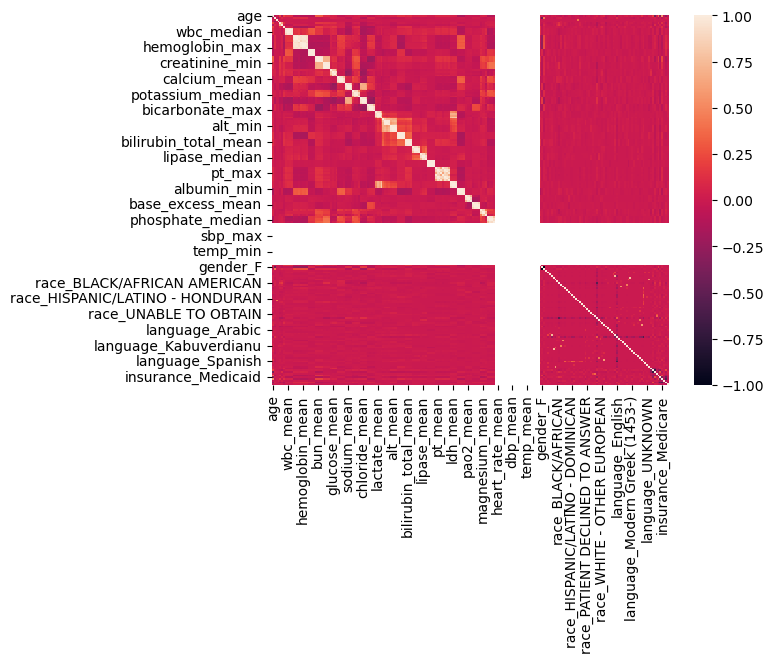

In [49]:
sns.heatmap(cormat)